In [1]:
import matplotlib as mpl #画图用的库
import matplotlib.pyplot as plt
#下面这一句是为了可以在notebook中画图
%matplotlib inline
import numpy as np
import sklearn   #机器学习算法库
import pandas as pd #处理数据的库   
import os
import sys
import time
import pprint
import shutil
import tensorflow as tf
 
from tensorflow import keras   #使用tensorflow中的keras
#import keras #单纯的使用keras
 
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, sklearn, pd, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
sklearn 0.21.3
pandas 0.25.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train_dir = '/home/galaxy/DeepLearning/DATASETS/dogs_and_cats/train/'
valid_dir = '/home/galaxy/DeepLearning/DATASETS/dogs_and_cats/validation/'
test_dir  = '/home/galaxy/DeepLearning/DATASETS/dogs_and_cats/test/'

#确认各路径是否正确
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(test_dir))

#打印各目录下的文件、文件夹
print(os.listdir(train_dir))
print(os.listdir(valid_dir))
print(os.listdir(test_dir))

#建立分类的标签 dog && cat
classes_name = ['cat', 'dog']

True
True
True
['dog', 'cat']
['dog', 'cat']
['100.jpg', '101.jpg', '66.jpg', '22.jpg', '44.jpg', '99.jpg', '11.jpg', '102.jpg', '33.jpg', '55.jpg']


In [4]:
#建立train文件的datagenerator

#resnet50模型要求的宽高均为224
height      = 224
width       = 224
#height      = 150
#width       = 150
channels    = 3
batch_size  = 24
num_classes = 2

#train datasets
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    #rescale           = 1./255, #放缩因子, 除以255是因为图片中每个像素点值范围都在0~255之间
    preprocessing_function = keras.applications.resnet50.preprocess_input,
    rotation_range    = 40,  #图片随机转动的角度范围(-40 ~ 40)
    width_shift_range = 0.2, #值 < 1时，表示偏移的比例，即在 0～值 这个比例幅度之间进行偏移
    height_shift_range= 0.2, #值 > 1时，表示像素宽度，即该图片的偏移幅度大小
    shear_range       = 0.2, #剪切强度
    zoom_range        = 0.2, #缩放强度
    horizontal_flip   = True,#水平随机翻转
    fill_mode         = 'nearest',#像素填充模式
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (height,width), #目录下的图片会被resize的大小
    batch_size  = batch_size,
    seed        = 7,#随机种子，用于洗牌和转换，随便给个数即可
    shuffle     = True,#False->则按字母数字顺序对数据进行排序 True->打乱数据
    class_mode  = "categorical", # 该参数决定了返回的标签数组的形式
    classes     = classes_name,
)
print(train_generator.class_indices)


#valid datasets
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    #rescale           = 1./255, #放缩因子, 除以255是因为图片中每个像素点值范围都在0~255之间
    preprocessing_function = keras.applications.resnet50.preprocess_input,
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (height,width), #目录下的图片会被resize的大小
    batch_size  = batch_size,
    seed        = 7,#随机种子，用于洗牌和转换，随便给个数即可
    shuffle     = False,#False->则按字母数字顺序对数据进行排序 True->打乱数据
    class_mode  = "categorical", # 该参数决定了返回的标签数组的形式
    classes     = classes_name,
)
print(valid_generator.class_indices)


train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 2000 images belonging to 2 classes.
{'cat': 0, 'dog': 1}
Found 1000 images belonging to 2 classes.
{'cat': 0, 'dog': 1}
2000 1000


In [5]:
'''
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu",input_shape=(width, height, channels)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),    
    keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),    
    keras.layers.MaxPool2D(pool_size=2),
    
    
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax"),
])
'''

resnet50_fine_tune = keras.models.Sequential([
    keras.applications.ResNet50(include_top = False,pooling = 'avg',weights = 'imagenet'),
    keras.layers.Dense(num_classes, activation = 'softmax')
])
resnet50_fine_tune.layers[0].trainable = False


resnet50_fine_tune.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
resnet50_fine_tune.summary()


callback_dir = "./cat_and_dog"
if os.path.exists(callback_dir):
    shutil.rmtree(callback_dir)
os.mkdir(callback_dir)
 
output_model_file=os.path.join(callback_dir,"cat_and_dog_model.h5")#在logdir中创建一个模型文件.h5
 
callbacks = [
    keras.callbacks.TensorBoard(callback_dir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True, save_weights_only=False),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3),    
]

epochs = 10#使用fine_tune 不需要太多次迭代就能够达到一个较好的效果
#使用fit_generator是因为使用的是 ImageDataGenerator 获取数据集数据的
history = resnet50_fine_tune.fit_generator(train_generator,#steps_per_epoch: 一个epoch包含的步数（每一步是一个batch的数据送入）
                              steps_per_epoch = train_num // batch_size,
                              epochs          = epochs,
                              validation_data = valid_generator,
                              validation_steps= valid_num // batch_size,
                              callbacks       = callbacks,
                             )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10
83/83 [==============================] - 45s 548ms/step - loss: 0.2920 - accuracy: 0.8816 - val_loss: 0.0968 - val_accuracy: 0.9614
Epoch 2/10
83/83 [==============================] - 43s 514ms/step - loss: 0.1189 - accuracy: 0.9555 - val_loss: 0.0347 - val_accuracy: 0.9888
Epoch 3/10
83/83 [==============================] - 42s 505ms/step - loss: 0.1362 - accuracy: 0.9494 - val_loss: 0.1070 - val_accuracy: 0.9604
Epoch 4/10
83/83 [==============================] - 42s 507ms/step - loss

(224, 224, 3)
(1, 224, 224, 3)
array([[9.9975449e-01, 2.4550335e-04]], dtype=float32)
[0]
[0]
This is a  cat


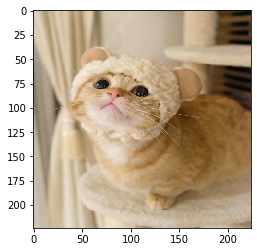

In [6]:
from tensorflow.keras.preprocessing import image

image_path_test = '/home/galaxy/DeepLearning/DATASETS/dogs_and_cats/test/100.jpg'

#显示要预测的图片
def preprocess_img(image):
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[width,height])
    image /= 255.0
    return image
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_img(image)
image_show = load_and_preprocess_image(image_path_test)
plt.imshow(image_show)

#加载图片至内存中并resize和增加维度
img = image.load_img(image_path_test, target_size=(height, width))
img = image.img_to_array(img)
print(img.shape)#这里直接打印将img转换为数组后的数据维度 (128,128,3)
img = np.expand_dims(img, axis=0)#因为模型的输入是要求四维的，所以我们需要将输入图片增加一个维度，使用 expand_dims接口
print(img.shape)


#predict表示预测输出当前输入图像的 所有类型概率数组，即包含十个概率值的数组
pred = resnet50_fine_tune.predict(img)
pprint.pprint(pred)
print(np.argmax(pred,axis=1))#axis参数：对于二维向量而言，0代表对行进行最大值选取，此时对每一列进行操作；1代表对列进行最大值选取，此时对每一行进行操作
 
#predict_classes 预测的是类别，打印出来的值就是类别号
pred_class = resnet50_fine_tune.predict_classes(img)
print(pred_class)
 
#建立对应的文件夹排序的标签数组打印出预测的标签
label_name = [classes_name[index] for index in pred_class]
print("This is a ",''.join(label_name))#list转换为string

In [7]:
#保存graph
tf.saved_model.save(resnet50_fine_tune,'./cat_and_dog/keras_saved_graph')
!saved_model_cli show --dir ./cat_and_dog/keras_saved_graph --all

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./cat_and_dog/keras_saved_graph/assets

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['resnet50_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, -1, -1, 3)
        name: serving_default_resnet50_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method n

In [8]:
#通过keras模型保存为 tflite 模型

loaded_keras_model = keras.models.load_model('./cat_and_dog/cat_and_dog_model.h5')
loaded_keras_model(np.ones((1,228,228,3)))

run_model = tf.function(lambda x : loaded_keras_model(x))
keras_concrete_function = run_model.get_concrete_function(
    tf.TensorSpec(shape=(1,224,224,3), dtype=np.float32,)#设置具体函数的入参必须为(1,224,224,3)
)
#keras_concrete_function(tf.constant(np.ones((1,228,228,3), dtype=np.float32)))

concrete_function_to_tflite_converter = tf.lite.TFLiteConverter.from_concrete_functions([keras_concrete_function])
concrete_function_tflite=concrete_function_to_tflite_converter.convert()

if not os.path.exists('./cat_and_dog/tflite_model'):
    os.mkdir('./cat_and_dog/tflite_model')
with open('./cat_and_dog/tflite_model/cat_and_dog_tflite', 'wb') as f:
    f.write(concrete_function_tflite)

[{'name': 'x', 'index': 186, 'shape': array([  1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
[{'name': 'Identity', 'index': 0, 'shape': array([1, 2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
(224, 224, 3)
(1, 224, 224, 3)
[[0.99324435 0.00675566]]
[0]
['cat']


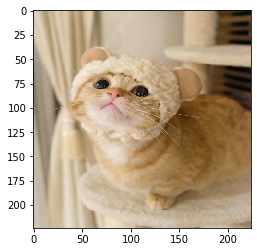

In [9]:
#加载tflite模型并进行预测

#interpreter = tf.lite.Interpreter(model_content=concrete_function_tflite)
interpreter = tf.lite.Interpreter(model_path='./cat_and_dog/tflite_model/cat_and_dog_tflite')
interpreter.allocate_tensors()

input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

input_shape = input_details[0]['shape']
# input_data  = tf.constant(tf.ones(input_shape,dtype=np.float32))

#设置输入图片的相关信息
from tensorflow.keras.preprocessing import image
image_path_test = '/home/galaxy/DeepLearning/DATASETS/dogs_and_cats/test/100.jpg'
#显示要预测的图片
def preprocess_img(image):
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[width,height])
    image /= 255.0
    return image
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_img(image)
image_show = load_and_preprocess_image(image_path_test)
plt.imshow(image_show)
#加载图片至内存中并resize和增加维度
img = image.load_img(image_path_test, target_size=(height, width))
img = image.img_to_array(img)
print(img.shape)#这里直接打印将img转换为数组后的数据维度 (128,128,3)
img = np.expand_dims(img, axis=0)#因为模型的输入是要求四维的，所以我们需要将输入图片增加一个维度，使用 expand_dims接口
print(img.shape)


interpreter.set_tensor(input_details[0]['index'],img)
interpreter.invoke()

output_results = interpreter.get_tensor(output_details[0]['index'])
print(output_results)
print(np.argmax(output_results,axis = 1))
label_name = [classes_name[index] for index in np.argmax(output_results,axis = 1)]
print(label_name)